# Quick Start

This quick start tutorial will demonstrate the basic usage of DNAMite. For more detailed usage see the User Guide.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Regression

We'll start by importing some packages and reading in the California Housing dataset, a standard regression dataset.

In [2]:
# Import california housing dataset
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
X, y = data["data"], data["target"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

To fit a DNAMite model to this data, we use DNAMiteRegressor. The only required input parameter is the number of features we'd like our model to have. We also input a device so that the model trains on GPU. The model will fit a neural network for each feature as well as all pairwise interactions.

In [7]:
from dnamite.models import DNAMiteRegressor

model = DNAMiteRegressor(
    n_features=X_train.shape[1],
    device=device,
)
model.fit(X_train, y_train)

Discretizing features...


100%|██████████| 8/8 [00:00<00:00, 676.32it/s]


SPlIT 0
TRAINING MAINS


Early stopping at 32 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 25 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
TRAINING MAINS


Early stopping at 26 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 22 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
TRAINING MAINS


Early stopping at 26 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 28 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
TRAINING MAINS


Early stopping at 35 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 20 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
TRAINING MAINS


Early stopping at 42 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 26 epochs: Test loss has not improved for 5 consecutive epochs.


Let's first check that our model has reasonable predictive accuracy.

In [9]:
preds = model.predict(X_test)
print(f"RMSE: {np.sqrt(np.mean((preds - y_test)**2))}")

RMSE: 0.4948946387309151


We can now start interpreting our model. First we can look at the top feature importances from the model.

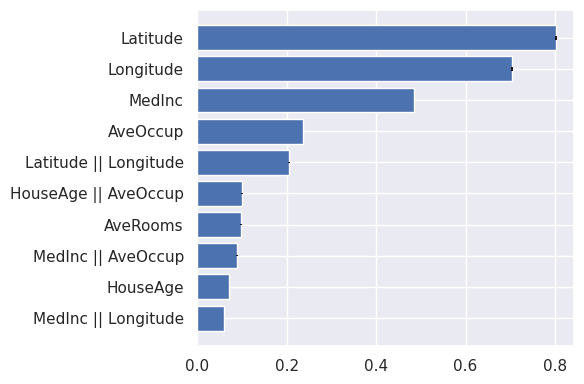

In [10]:
model.plot_feature_importances(k=10)

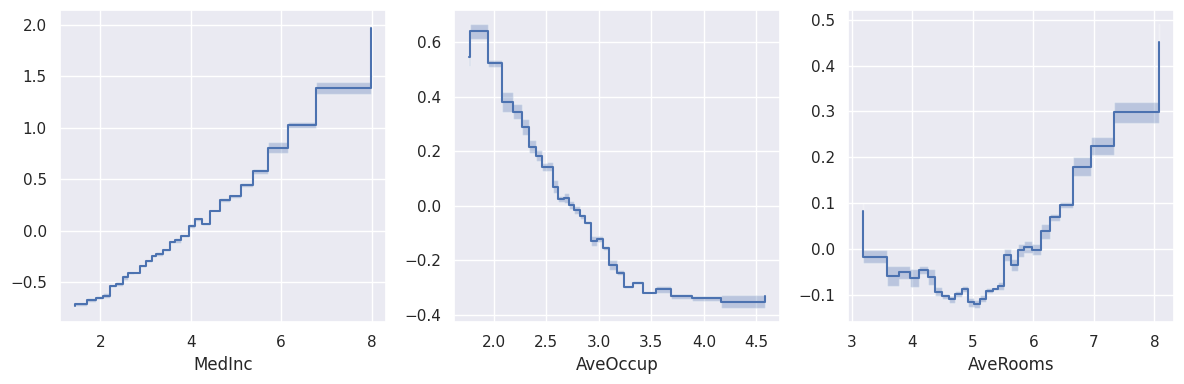

In [11]:
model.plot_shape_function(["MedInc", "AveOccup", "AveRooms"])

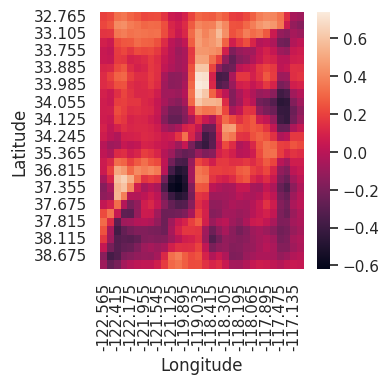

In [13]:
model.plot_pair_shape_function("Latitude", "Longitude")

## Survival Analysis

Now we'll switch gears and train a DNAMite model for survival analysis. Briefly, survival analysis involves predicting the probability that a time-to-event variable $T$ happens before $t$ for all times $t > 0$. See the User Guide for more details on survival analysis. We'll use the flchain dataset from scikit-survival.

In [14]:
from sksurv.datasets import load_flchain
X, y = load_flchain()

# Change y dtypes and names
y.dtype = np.dtype([('event', '?'), ('time', '<f8')])

# # Impute chapter with new category
X["chapter"] = X["chapter"].astype("category")
X["chapter"] = X["chapter"].cat.add_categories("Unknown")
X["chapter"] = X["chapter"].fillna("Unknown")

# Clip Training data to avoid overflow errors
X["creatinine"] = X["creatinine"].clip(-5, 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [15]:
X_train

,age,chapter,creatinine,flc.grp,kappa,lambda,mgus,sample.yr,sex
5471,56.0,Unknown,0.9,5,1.140,1.450,no,1996,F
2512,65.0,Unknown,1.2,2,0.828,1.160,no,1997,M
4242,62.0,Unknown,1.1,9,1.460,2.470,no,2000,F
810,79.0,Infectious,1.2,9,2.070,1.900,no,1997,M
1483,70.0,Unknown,NaN,5,1.130,1.530,no,2002,F
...,...,...,...,...,...,...,...,...,...
3441,67.0,Unknown,1.0,1,0.316,0.972,no,1996,F
1344,76.0,Circulatory,1.1,5,1.500,1.300,no,2001,F
4623,62.0,Unknown,1.1,8,1.840,1.920,no,1996,F
7293,52.0,Unknown,0.9,2,0.877,0.946,no,1996,F


Fitting a DNAMite model for survival analysis is very similar to fitting a DNAMite regression model. 

In [16]:
from dnamite.models import DNAMiteSurvival

model = DNAMiteSurvival(
    n_features=X_train.shape[1],
    device=device,
)
model.fit(X_train, y_train)

Discretizing features...


100%|██████████| 9/9 [00:00<00:00, 936.62it/s]


SPlIT 0
TRAINING MAINS


Early stopping at 27 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 7 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
TRAINING MAINS


Early stopping at 22 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 21 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
TRAINING MAINS


Early stopping at 31 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
TRAINING MAINS


Early stopping at 39 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
TRAINING MAINS


Early stopping at 34 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.


In [17]:
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored

def get_auc(surv_preds, y_train, y_test, eval_times):
    test_times = np.linspace(
        max(y_train["time"].min(), y_test[y_test["event"] > 0]["time"].min()) + 1e-4,
        min(y_train["time"].max(), y_test[y_test["event"] > 0]["time"].max()) - 1e-4,
        1000
    )
    
    surv_preds = surv_preds[
        :, 
        np.clip(
            np.searchsorted(eval_times.cpu().numpy(), test_times),
            0, surv_preds.shape[1]-1
        )
    ]
    risk_preds = -1 * np.log(np.clip(surv_preds, 1e-5, 10 - 1e-5))
    # Get time-dependent AUC
    _, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_preds, test_times)
    
    return mean_auc

In [19]:
# After fixing categorical features
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

test_preds = model.predict(X_test)
surv_preds = 1 - sigmoid(test_preds)
auc = get_auc(surv_preds, y_train, y_test, model.eval_times)
auc

0.9502138376014964

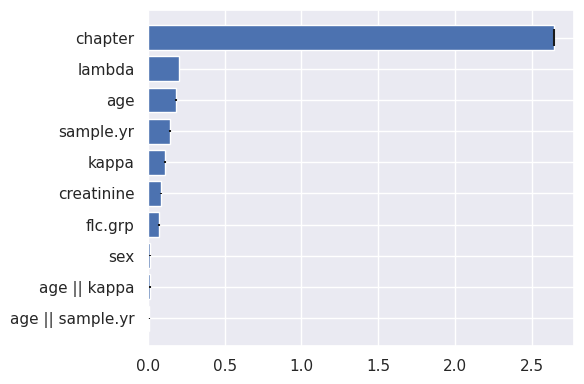

In [20]:
model.plot_feature_importances(k=10, eval_time=365*5)

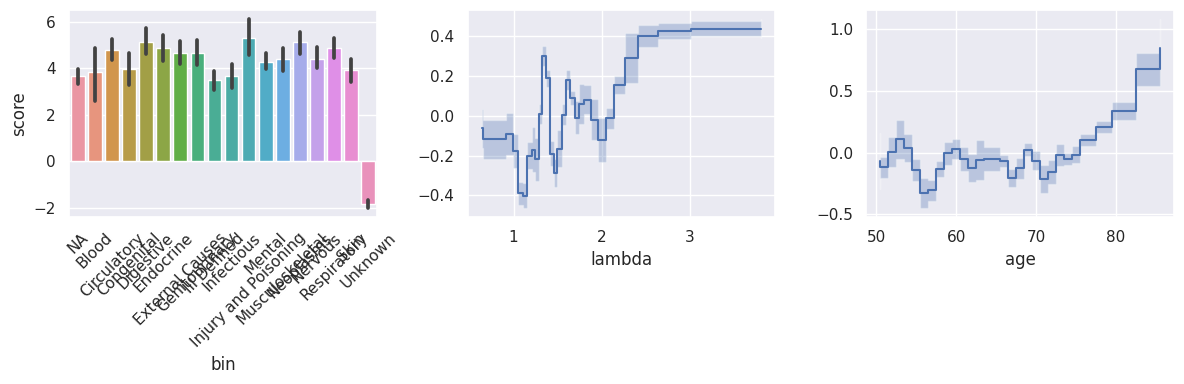

In [21]:
model.plot_shape_function(["chapter", "lambda", "age"], eval_time=365*5, is_cat_cols=[True, False, False])